# CS 109A/AC 209A/STAT 121A Data Science: Midterm 2
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Tuesday, November 22nd, 2016 at 12:00pm

Clear namespace

In [1]:
# Clear namespace
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

Import libraries

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Ploting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Scientific computing
import scipy as sp
from scipy.stats import spearmanr

# Machine Learning
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV

# Other
import timeit

# Part I: Diagnosing the Semian Flu 2016

You are given the early data for an outbreak of a dangerous virus originating from a group of primates being keeped in a Massechussetts biomedical research lab, this virus is dubbed the "Semian Flu".

You have the medical records of $n$ number of patients in `'flu_train.csv`. There are two general types of patients in the data, flu patients and healthy (this is recorded in the column labeled `flu`, a 0 indicates the absences of the virus and a 1 indicates presence). Furthermore, scientists have found that there are two strains of the virus, each requiring a different type of treatment (this is recorded in the column labeled `flutype`, a 1 indicates the absences of the virus, a 2 indicates presence of strain 1 and a 3 indicates the presence of strain 2).

**Your task:** build a model to predict if a given patient has the flu. Your goal is to catch as many flu patients as possible without misdiagnosing too many healthy patients.

**The deliverable:** a function called `flu_predict` which satisfies:

- input: `x_test`, a set of medical predictors for a group of patients
- output: `y_pred`, a set of labels, one for each patient; 0 for healthy and 1 for infected with the flu virus

The MA state government will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

We provide you with some benchmarks for comparison.

**Baseline Model:** 
- ~50% expected accuracy on healthy patients in observed data
- ~50% expected accuracy on flu patients in observed data
- ~50% expected accuracy on healthy patients in future data 
- ~50% expected accuracy on flu patients in future data
- time to build: 5 min

**Reasonable Model:** 
- ~69% expected accuracy on healthy patients in observed data
- ~55% expected accuracy on flu patients, in observed data
- ~69% expected accuracy on healthy patients in future data
- ~60% expected accuracy on flu patients, in future data
- time to build: 20 min

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform our benchmarks
2. your ability to carefully and thoroughly follow the data science pipeline (see lecture slides for definition)
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

## Functions (necessary for the following calculations)

In [3]:
#--------  table
# A function that is similar to the R table function
# Input: 
#      x (x values)
# Returns: 
#      table (table)

def table(x):
    table = pd.DataFrame(x.value_counts(dropna=True))
    return table

## 1: Importing Data

In [4]:
# load business data
df_flu = pd.read_csv('datasets/flu_train.csv')
df_flu_fin = pd.read_csv('datasets/flu_test_no_y.csv')

In [5]:
print "shape: ", df_flu.shape
df_flu[0:5]

shape:  (5246, 76)


,ID,Gender,Age,AgeDecade,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,...,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow,flu,flutype
0,51624,male,34,30-39,409.0,White,NaN,High School,Married,25000-34999,...,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN,0,1
1,51630,female,49,40-49,596.0,White,NaN,Some College,LivePartner,35000-44999,...,Yes,Yes,12.0,10.0,1.0,Yes,Heterosexual,NaN,0,1
2,51638,male,9,0-9,115.0,White,NaN,NaN,NaN,75000-99999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,51646,male,8,0-9,101.0,White,NaN,NaN,NaN,55000-64999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,51647,female,45,40-49,541.0,White,NaN,College Grad,Married,75000-99999,...,No,Yes,13.0,20.0,0.0,Yes,Bisexual,NaN,0,1


## 2: Data Cleaning

In [9]:
# Transform column headers to lower case
df_flu.columns = map(str.lower, df_flu.columns)
df_flu_fin.columns = map(str.lower, df_flu_fin.columns)

# Replace whitespace in headers
df_flu.columns = [x.strip().replace(' ', '_') for x in df_flu.columns]
df_flu_fin.columns = [x.strip().replace(' ', '_') for x in df_flu_fin.columns]


Variable names and variable encoding

In [15]:
# Extract variable names
var_names = df_flu.columns.values
print var_names

# List of columns to be converted to floating point
cat_var = df_flu.dtypes[df_flu.dtypes == "object"].index.values
num_var = var_names[~df_flu.columns.isin(cat_var)]

# Converted columns to floating point
for feature_name in num_var:
    df_flu.loc[:, feature_name] = df_flu.loc[:, feature_name].astype(float)

['id' 'gender' 'age' 'agedecade' 'agemonths' 'race1' 'race3' 'education'
 'maritalstatus' 'hhincome' 'hhincomemid' 'poverty' 'homerooms' 'homeown'
 'work' 'weight' 'length' 'headcirc' 'height' 'bmi' 'bmicatunder20yrs'
 'bmi_who' 'pulse' 'bpsysave' 'bpdiaave' 'bpsys1' 'bpdia1' 'bpsys2'
 'bpdia2' 'bpsys3' 'bpdia3' 'testosterone' 'directchol' 'totchol'
 'urinevol1' 'urineflow1' 'urinevol2' 'urineflow2' 'diabetes' 'diabetesage'
 'healthgen' 'daysmenthlthbad' 'littleinterest' 'depressed' 'npregnancies'
 'nbabies' 'age1stbaby' 'sleephrsnight' 'sleeptrouble' 'physactive'
 'physactivedays' 'tvhrsday' 'comphrsday' 'tvhrsdaychild' 'comphrsdaychild'
 'alcohol12plusyr' 'alcoholday' 'alcoholyear' 'smokenow' 'smoke100'
 'smoke100n' 'smokeage' 'marijuana' 'agefirstmarij' 'regularmarij'
 'ageregmarij' 'harddrugs' 'sexever' 'sexage' 'sexnumpartnlife'
 'sexnumpartyear' 'samesex' 'sexorientation' 'pregnantnow' 'flu' 'flutype']


In [17]:
# Extract variable names
var_names = df_flu_fin.columns.values

# List of columns to be converted to floating point
cat_var = df_flu_fin.dtypes[df_flu_fin.dtypes == "object"].index.values
num_var = var_names[~df_flu_fin.columns.isin(cat_var)]

for feature_name in num_var:
    df_flu_fin.loc[:, feature_name] = df_flu_fin.loc[:, feature_name].astype(float)


Missing variables

In [18]:
# Count missings
df_null = table(df_flu[var_names[0]].isnull())
for i in range(1, len(var_names)):
    df_new = table(df_flu[var_names[i]].isnull())
    df_null = pd.concat([df_null, df_new], axis=1)

In [19]:
pd.set_option('display.max_columns', None)
df_null.loc[:, ~df_null.iloc[1, :].isnull().values]
df_null

,id,gender,age,agedecade,agemonths,race1,race3,education,maritalstatus,hhincome,hhincomemid,poverty,homerooms,homeown,work,weight,length,headcirc,height,bmi,bmicatunder20yrs,bmi_who,pulse,bpsysave,bpdiaave,bpsys1,bpdia1,bpsys2,bpdia2,bpsys3,bpdia3,testosterone,directchol,totchol,urinevol1,urineflow1,urinevol2,urineflow2,diabetes,diabetesage,healthgen,daysmenthlthbad,littleinterest,depressed,npregnancies,nbabies,age1stbaby,sleephrsnight,sleeptrouble,physactive,physactivedays,tvhrsday,comphrsday,tvhrsdaychild,comphrsdaychild,alcohol12plusyr,alcoholday,alcoholyear,smokenow,smoke100,smoke100n,smokeage,marijuana,agefirstmarij,regularmarij,ageregmarij,harddrugs,sexever,sexage,sexnumpartnlife,sexnumpartyear,samesex,sexorientation,pregnantnow
False,5246.0,5246.0,5246.0,5057,2726,5246.0,2508,3574,3580,4798,4798,4843,5210,5213,3889,5206,356,61,5014,5010,724,4990,4376,4369,4369,4213,4213,4263,4263,4261,4261,2008,4337,4337,4637,4300,763,763,5143,330,3783,3778,3292,3295,1283,1182,941,3879,3890,4204,2374,2417,2419,417,417,3232,2404,2882,1539,3581,3581,1479,2411,1331,2411,629,2798,2796,2673,2773,2405,2798,2357,883
True,NaN,NaN,NaN,189,2520,NaN,2738,1672,1666,448,448,403,36,33,1357,40,4890,5185,232,236,4522,256,870,877,877,1033,1033,983,983,985,985,3238,909,909,609,946,4483,4483,103,4916,1463,1468,1954,1951,3963,4064,4305,1367,1356,1042,2872,2829,2827,4829,4829,2014,2842,2364,3707,1665,1665,3767,2835,3915,2835,4617,2448,2450,2573,2473,2841,2448,2889,4363


If missing and categorical fill the variable with 'unknown'

In [21]:
# df flu
#-------
# Transform categorical na's to unknown
df_flu[cat_var] = df_flu[cat_var].fillna('Unknown')

# Transform sensible numerical na's to zero
df_flu.loc[df_flu.npregnancies.isnull(), 'npregnancies'] = 0
df_flu.loc[df_flu.age1stbaby.isnull(), 'age1stbaby'] = 0
df_flu.loc[df_flu.smokeage.isnull(), 'smokeage'] = 0

# Replace homerooms with mean value
df_flu.loc[df_flu.homerooms.isnull(), 'homerooms'] = round(df_flu.loc[:, 'homerooms'].mean(), 0)
df_flu.loc[df_flu.daysmenthlthbad.isnull(), 'daysmenthlthbad'] = round(df_flu.loc[:, 'daysmenthlthbad'].mean(), 0)
df_flu.loc[df_flu.homerooms.isnull(), 'hhincomemid'] = round(df_flu.loc[:, 'hhincomemid'].mean(), 0)
df_flu.loc[df_flu.bmi.isnull(), 'bmi'] = round(df_flu.loc[:, 'bmi'].mean(), 0)
df_flu.loc[df_flu.pulse.isnull(), 'pulse'] = round(df_flu.loc[:, 'pulse'].mean(), 0)
df_flu.loc[df_flu.hhincomemid.isnull(), 'hhincomemid'] = round(df_flu.loc[:, 'hhincomemid'].mean(), 0)
df_flu.loc[df_flu.directchol.isnull(), 'directchol'] = round(df_flu.loc[:, 'directchol'].mean(), 0)
df_flu.loc[df_flu.totchol.isnull(), 'totchol'] = round(df_flu.loc[:, 'totchol'].mean(), 0)
df_flu.loc[df_flu.sleephrsnight.isnull(), 'sleephrsnight'] = round(df_flu.loc[:, 'sleephrsnight'].mean(), 0)
df_flu.loc[df_flu.physactivedays.isnull(), 'physactivedays'] = round(df_flu.loc[:, 'physactivedays'].mean(), 0)
df_flu.loc[df_flu.alcoholday.isnull(), 'alcoholday'] = round(df_flu.loc[:, 'alcoholday'].mean(), 0)
df_flu.loc[df_flu.alcoholyear.isnull(), 'alcoholyear'] = round(df_flu.loc[:, 'alcoholyear'].mean(), 0)

# df flu fin
#-----------
# Transform categorical na's to unknown
df_flu_fin[cat_var] = df_flu_fin[cat_var].fillna('Unknown')

# Transform sensible numerical na's to zero
df_flu_fin.loc[df_flu_fin.npregnancies.isnull(), 'npregnancies'] = 0
df_flu_fin.loc[df_flu_fin.age1stbaby.isnull(), 'age1stbaby'] = 0
df_flu_fin.loc[df_flu_fin.smokeage.isnull(), 'smokeage'] = 0

# Replace homerooms with mean value
df_flu_fin.loc[df_flu_fin.homerooms.isnull(), 'homerooms'] = round(df_flu_fin.loc[:, 'homerooms'].mean(), 0)
df_flu_fin.loc[df_flu_fin.daysmenthlthbad.isnull(), 'daysmenthlthbad'] = round(df_flu_fin.loc[:, 'daysmenthlthbad'].mean(), 0)
df_flu_fin.loc[df_flu_fin.homerooms.isnull(), 'hhincomemid'] = round(df_flu_fin.loc[:, 'hhincomemid'].mean(), 0)
df_flu_fin.loc[df_flu_fin.bmi.isnull(), 'bmi'] = round(df_flu_fin.loc[:, 'bmi'].mean(), 0)
df_flu_fin.loc[df_flu_fin.pulse.isnull(), 'pulse'] = round(df_flu_fin.loc[:, 'pulse'].mean(), 0)
df_flu_fin.loc[df_flu_fin.hhincomemid.isnull(), 'hhincomemid'] = round(df_flu_fin.loc[:, 'hhincomemid'].mean(), 0)
df_flu_fin.loc[df_flu_fin.directchol.isnull(), 'directchol'] = round(df_flu_fin.loc[:, 'directchol'].mean(), 0)
df_flu_fin.loc[df_flu_fin.totchol.isnull(), 'totchol'] = round(df_flu_fin.loc[:, 'totchol'].mean(), 0)
df_flu_fin.loc[df_flu_fin.sleephrsnight.isnull(), 'sleephrsnight'] = round(df_flu_fin.loc[:, 'sleephrsnight'].mean(), 0)
df_flu_fin.loc[df_flu_fin.physactivedays.isnull(), 'physactivedays'] = round(df_flu_fin.loc[:, 'physactivedays'].mean(), 0)
df_flu_fin.loc[df_flu_fin.alcoholday.isnull(), 'alcoholday'] = round(df_flu_fin.loc[:, 'alcoholday'].mean(), 0)
df_flu_fin.loc[df_flu_fin.alcoholyear.isnull(), 'alcoholyear'] = round(df_flu_fin.loc[:, 'alcoholyear'].mean(), 0)

** id **
The id variable is the unique identifier. It has to be excluded.

** Age **
As can be seen above, agedecade and agemonts have missing values while the age has non. Age in months is completly excluded as is has no many missings and is probalby not an important predictor anyhow. The age in decades can be derived from age and is heavily corellated as well.

** Race **
The race variable 1 encodes the same races as race 3. However race 3 has additionaly the category Asian but has missings. The variables are combined to a new variable where there are no missings.

** Length, headcirc, bmicatunder20yrs, diabetesage, tvhrsdaychild, comphrsdaychild, ageregmarij, testosterone, agefirstmarij **
They have so many missings that they are very difficult to use and other variables either control for them or it is reasanable to exclude them. 

** Ethical note:** In this context it is ethiticly sound to use race and gender as variables. This is because they could have explenatory power but identify correctly the flu has no discriminatory effect.


In [22]:
# df flu
#-------
# Education
df_flu.loc[df_flu.education.isnull(), 'education'] = "Unknown"

# Recode martial status
df_flu.loc[~((df_flu.maritalstatus.isnull()) | (df_flu.maritalstatus == 'Married')), 'maritalstatus'] = "Not_Married"
df_flu.loc[df_flu.maritalstatus.isnull(), 'maritalstatus'] = "Unknown"

# Replace race values 
df_flu.loc[:, 'race'] = df_flu['race3']
df_flu.loc[df_flu['race'].isnull(), 'race'] = df_flu.loc[df_flu['race'].isnull(), 'race1']

# Drop variables 
drop_var = ["id", "agedecade", "agemonths", "race1", "race3", "length", "headcirc", "testosterone", "bmicatunder20yrs", "diabetesage", "tvhrsdaychild", "comphrsdaychild", "ageregmarij", "agefirstmarij"]
keep_var = df_flu.columns[~df_flu.columns.isin(drop_var)]
df_flu = df_flu[keep_var]

# df flu fin
#-----------
# Education
df_flu_fin.loc[df_flu_fin.education.isnull(), 'education'] = "Unknown"

# Recode martial status
df_flu_fin.loc[~((df_flu_fin.maritalstatus.isnull()) | (df_flu_fin.maritalstatus == 'Married')), 'maritalstatus'] = "Not_Married"
df_flu_fin.loc[df_flu_fin.maritalstatus.isnull(), 'maritalstatus'] = "Unknown"

# Replace race values 
df_flu_fin.loc[:, 'race'] = df_flu_fin['race3']
df_flu_fin.loc[df_flu['race'].isnull(), 'race'] = df_flu_fin.loc[df_flu_fin['race'].isnull(), 'race1']

# Drop variables 
drop_var = ["id", "agedecade", "agemonths", "race1", "race3", "length", "headcirc", "testosterone", "bmicatunder20yrs", "diabetesage", "tvhrsdaychild", "comphrsdaychild", "ageregmarij", "agefirstmarij"]
keep_var = df_flu_fin.columns[~df_flu_fin.columns.isin(drop_var)]
df_flu_fin = df_flu_fin[keep_var]

Categories with only a few occurunces

In [24]:
# df flu
#-------
df_flu.loc[df_flu.homeown == 'Unknown', 'homeown'] = "Other"
df_flu.loc[df_flu.work == 'Unknown', 'work'] = "Other"
df_flu.loc[df_flu.tvhrsday.isin(["3_hr", "4_hr", "More_4_hr"]), 'tvhrsday'] = "3_or_more_hr"

# df flu fin
#-----------
df_flu_fin.loc[df_flu_fin.homeown == 'Unknown', 'homeown'] = "Other"
df_flu_fin.loc[df_flu_fin.work == 'Unknown', 'work'] = "Other"
df_flu_fin.loc[df_flu_fin.tvhrsday.isin(["3_hr", "4_hr", "More_4_hr"]), 'tvhrsday'] = "3_or_more_hr"


The Spearman rank correlation coefficient, rs , is a nonparametric measure of correlation based on data ranks. It is obtained by ranking the values of the two variables (X and Y) and calculating the Pearson rp on the resulting ranks. The advantage of the Spearman rank correlation coefficient is that the X and Y values can be continuous or ordinal. That is why it is used here.

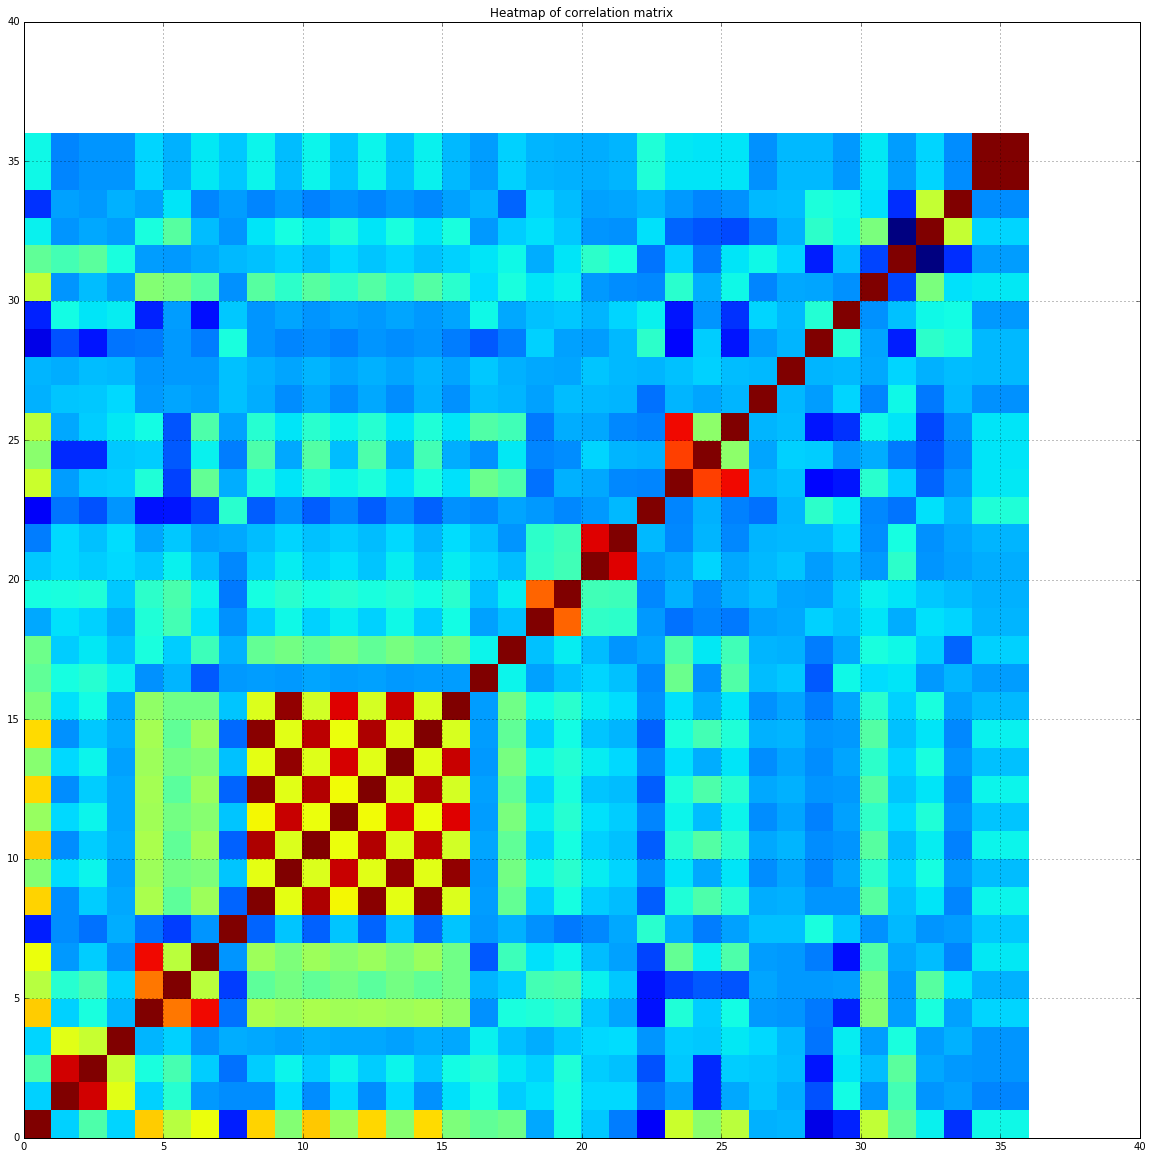

In [25]:
# Correlation 
corr_matrix = df_flu.corr(method="spearman")

# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

ax.pcolor(corr_matrix)
ax.set_title('Heatmap of correlation matrix')
ax.grid()
plt.show()

The heat map as well as the correlation matrix shows that some of the predictors (marked by the color red) are correlated amongst themselves.

In [26]:
corr_matrix

,age,hhincomemid,poverty,homerooms,weight,height,bmi,pulse,bpsysave,bpdiaave,bpsys1,bpdia1,bpsys2,bpdia2,bpsys3,bpdia3,directchol,totchol,urinevol1,urineflow1,urinevol2,urineflow2,daysmenthlthbad,npregnancies,nbabies,age1stbaby,sleephrsnight,physactivedays,alcoholday,alcoholyear,smokeage,sexage,sexnumpartnlife,sexnumpartyear,flu,flutype
age,1.000000,0.028933,0.193999,0.034219,0.557354,0.382616,0.472411,-0.223376,0.546726,0.292232,0.561878,0.325356,0.540107,0.295472,0.533722,0.276902,0.229572,0.252555,-0.025893,0.097017,0.015558,-0.089875,-0.291180,0.413983,0.301199,0.383298,-0.014003,-0.010234,-0.318159,-0.219312,0.399126,0.225003,0.074638,-0.199486,0.086335,0.087716
hhincomemid,0.028933,1.000000,0.894293,0.452291,0.026768,0.127238,-0.048542,-0.068457,-0.066320,0.044845,-0.069352,0.041477,-0.064774,0.043117,-0.063799,0.054107,0.095501,0.025612,0.049177,0.102159,0.038860,0.037826,-0.099976,-0.042527,-0.211471,-0.026522,0.012346,-0.021698,-0.152383,0.090485,-0.056427,0.177402,-0.054467,-0.036310,-0.078384,-0.078572
poverty,0.193999,0.894293,1.000000,0.408328,0.104983,0.182484,0.022712,-0.106283,0.022357,0.082640,0.023606,0.081067,0.024528,0.079009,0.020303,0.088571,0.123877,0.064914,0.029671,0.112139,0.025737,0.007266,-0.149445,0.019474,-0.210000,0.026015,0.020508,-0.000803,-0.234888,0.056185,0.002829,0.217386,-0.025297,-0.051002,-0.055360,-0.055144
homerooms,0.034219,0.452291,0.408328,1.000000,-0.013075,0.028887,-0.062440,-0.020503,-0.026229,-0.037116,-0.024313,-0.030235,-0.026956,-0.037979,-0.019102,-0.027618,0.076992,0.003695,-0.021917,0.016319,0.037742,0.046641,-0.057821,0.025860,0.019830,0.065734,0.040207,-0.005430,-0.102930,0.068513,-0.047281,0.104643,-0.047289,-0.015147,-0.056579,-0.056848
weight,0.557354,0.026768,0.104983,-0.013075,1.000000,0.687848,0.856757,-0.107407,0.355787,0.335541,0.355865,0.342757,0.348634,0.336996,0.348913,0.312529,-0.062876,0.102681,0.115205,0.136562,0.020222,-0.030979,-0.241684,0.115900,0.025257,0.093522,-0.049063,-0.055953,-0.093658,-0.220016,0.286683,-0.045716,0.101659,-0.039159,0.035597,0.036042
height,0.382616,0.127238,0.182484,0.028887,0.687848,1.000000,0.384586,-0.180858,0.223047,0.262312,0.227286,0.262777,0.213104,0.259023,0.226284,0.254311,-0.008445,0.021482,0.178908,0.185074,0.072229,0.018079,-0.235660,-0.171957,-0.143220,-0.149076,-0.030406,-0.047966,-0.052635,-0.044471,0.273081,-0.050732,0.212346,0.059533,-0.016885,-0.016921
bmi,0.472411,-0.048542,0.022712,-0.062440,0.856757,0.384586,1.000000,-0.055185,0.336773,0.280516,0.334985,0.293164,0.331414,0.282617,0.327302,0.257359,-0.142773,0.165600,0.050688,0.078677,0.001737,-0.037196,-0.170142,0.231025,0.072117,0.191039,-0.042921,-0.048707,-0.087767,-0.247641,0.205083,-0.025283,0.002204,-0.080398,0.061170,0.061793
pulse,-0.223376,-0.068457,-0.106283,-0.020503,-0.107407,-0.180858,-0.055185,1.000000,-0.124058,0.012708,-0.131726,0.011626,-0.121916,0.008657,-0.116744,0.013131,-0.048940,-0.017322,-0.064175,-0.094796,-0.070399,-0.027971,0.130196,-0.019199,-0.087352,-0.037938,0.006600,0.006073,0.103364,0.019636,-0.060835,-0.005813,-0.054960,-0.046973,0.019463,0.019251
bpsysave,0.546726,-0.066320,0.022357,-0.026229,0.355787,0.223047,0.336773,-0.124058,1.000000,0.460086,0.941664,0.486047,0.985708,0.461620,0.985168,0.440902,-0.043118,0.231903,0.025573,0.099369,0.025048,0.000329,-0.135656,0.112632,0.191169,0.126684,-0.023148,-0.017517,-0.058497,-0.053425,0.208547,0.007250,0.059105,-0.078827,0.079941,0.081032
bpdiaave,0.292232,0.044845,0.082640,-0.037116,0.335541,0.262312,0.280516,0.012708,0.460086,1.000000,0.444820,0.904659,0.451284,0.975596,0.452844,0.976032,-0.050705,0.263140,0.087436,0.130654,0.067772,0.035348,-0.069105,0.058770,-0.025979,0.059261,-0.064822,-0.034609,-0.081156,-0.035280,0.136479,0.029631,0.098724,-0.049160,0.003045,0.003202


There are a couple of heavaly correlated features. We are excluding them, as they could pose a problem for some of the algorithms and we have a lot of variables and not that many observations. With this situation we could be faced with a problem of "curse of dimensionality". Features that are heavily correlated, but have more NA's or less explanatory power with the targed variable (linear correlation) are excluded. An alternative would be to use PCA, however, this has a linearity assumtion and it would also make it harder to understand the model. However, knowing the most important factors (variable importance) could be very helpful for the application of the model in practice.

#### Heavily correlated

** poverty & hhincomeid**
Heavily correlated, but hhincomemid has a higher correlation with the target variable.

** weight & bmi **
They are heavaly correlated, however, bmi is a better variable in explaining the target variable.

** nbabies, age1stbaby & npregnancies **
Correlated. npregnancies explained more in the targed variable which means that the nbabies and age1stbaby is droped.

** height & testosterone **
Correlated, however, testosterone explaines more.

** hhincome & hhincomemid **
hhincom is the categorical derivative from hhincomeid, we are droping hhincome. 

** bmi & bmi_who **
bmi_who is the categorical derivative of bmi, we are droping bmi_who


In [27]:
# df flu
#-------
# Drop variables 
drop_var = ["poverty", "weight", "nbabies", "age1stbaby", "height", "hhincome", "bmi_who"]
keep_var = df_flu.columns[~df_flu.columns.isin(drop_var)]
df_flu = df_flu[keep_var]

# df flu fin
#-----------
# Drop variables 
drop_var = ["poverty", "weight", "nbabies", "age1stbaby", "height", "hhincome", "bmi_who"]
keep_var = df_flu_fin.columns[~df_flu_fin.columns.isin(drop_var)]
df_flu_fin = df_flu_fin[keep_var]

There is further a bp cluster of variables where a new feature could be constructed.

In [29]:
## Create new variables of the heavily correlated variables 

# df flu
#-------
# Correlations
bp_corr = ["bpsysave", "bpdiaave", "bpsys1", "bpdia1", "bpsys2", "bpdia2", "bpsys3", "bpdia3"]
urine_corr = ["urinevol1", "urineflow1", "urinevol2", "urineflow2"]
sexlife_corr = ["sexage", "sexnumpartnlife", "sexnumpartyear"]

# Extract df's
df_corr_bp = df_flu[bp_corr]
df_corr_urine = df_flu[urine_corr]
df_corr_sexlife = df_flu[sexlife_corr]

# Fill na with either mean or zeros
df_corr_bp = df_corr_bp.fillna(df_corr_bp.mean())
df_corr_urine = df_corr_urine.fillna(df_corr_urine.mean())
df_flu.loc[df_flu.sexage.isnull(), 'sexage'] = 0      # Zero is reasnable here
df_corr_sexlife = df_corr_sexlife.fillna(df_corr_sexlife.mean())

#Apply PCA to data and get the top 3 axes of maximum variation
pca_bp = PCA(n_components=5).fit(df_corr_bp)
pca_urine = PCA(n_components=3).fit(df_corr_urine)
pca_sexlife = PCA(n_components=3).fit(df_corr_sexlife)

# Printing
#---------
print "explained variance of the bp pca", pca_bp.explained_variance_ratio_
print "explained variance of the urine pca", np.round(pca_urine.explained_variance_ratio_, 3)
print "explained variance of the sexlife pca", np.round(pca_sexlife.explained_variance_ratio_, 3)

explained variance of the bp pca [ 0.66599963  0.26943035  0.02163599  0.01665446  0.01381361]
explained variance of the urine pca [ 0.859  0.141  0.   ]
explained variance of the sexlife pca [ 0.959  0.04   0.001]


It can be seen, that the first principal component explaines in the case of bp almost 88.6 % and in the case of urine 77% and in the case of sexlife 96% of the variablity. We are only using this component for the further modeling.

In [31]:
# Use 1 principal component
pca_bp = PCA(n_components=2).fit(df_corr_bp)
pca_urine = PCA(n_components=1).fit(df_corr_urine)
pca_sexlife = PCA(n_components=1).fit(df_corr_sexlife)

# Transform variables
bp_pca_vars = pca_bp.transform(df_corr_bp)
urine_pca_vars = pca_urine.transform(df_corr_urine)
sexlife_pca_vars = pca_sexlife.transform(df_corr_sexlife)

# Remove values and add principal component
keep_var = df_flu.columns[~df_flu.columns.isin(bp_corr)]
df_flu = df_flu[keep_var]
keep_var = df_flu.columns[~df_flu.columns.isin(urine_corr)]
df_flu = df_flu[keep_var]
keep_var = df_flu.columns[~df_flu.columns.isin(sexlife_corr)]
df_flu = df_flu[keep_var]

df_flu['bp_pca1_vars'] = pd.DataFrame(bp_pca_vars)[0]
df_flu['bp_pca2_vars'] = pd.DataFrame(bp_pca_vars)[1]
df_flu['urine_pca_vars'] = urine_pca_vars
df_flu['sexlife_pca_vars'] = sexlife_pca_vars

# df flu fin
#-----------
# Extract df's
df_corr_bp = df_flu_fin[bp_corr]
df_corr_urine = df_flu_fin[urine_corr]
df_corr_sexlife = df_flu_fin[sexlife_corr]

# Fill na with either mean or zeros
df_corr_bp = df_corr_bp.fillna(df_corr_bp.mean())
df_corr_urine = df_corr_urine.fillna(df_corr_urine.mean())
df_flu_fin.loc[df_flu_fin.sexage.isnull(), 'sexage'] = 0      # Zero is reasnable here
df_corr_sexlife = df_corr_sexlife.fillna(df_corr_sexlife.mean())

# Use 1 principal component
pca_bp = PCA(n_components=2).fit(df_corr_bp)
pca_urine = PCA(n_components=1).fit(df_corr_urine)
pca_sexlife = PCA(n_components=1).fit(df_corr_sexlife)

# Transform variables
bp_pca_vars = pca_bp.transform(df_corr_bp)
urine_pca_vars = pca_urine.transform(df_corr_urine)
sexlife_pca_vars = pca_sexlife.transform(df_corr_sexlife)

# Remove values and add principal component
keep_var = df_flu_fin.columns[~df_flu_fin.columns.isin(bp_corr)]
df_flu_fin = df_flu_fin[keep_var]
keep_var = df_flu_fin.columns[~df_flu_fin.columns.isin(urine_corr)]
df_flu_fin = df_flu_fin[keep_var]
keep_var = df_flu_fin.columns[~df_flu_fin.columns.isin(sexlife_corr)]
df_flu_fin = df_flu_fin[keep_var]

df_flu_fin['bp_pca1_vars'] = pd.DataFrame(bp_pca_vars)[0]
df_flu_fin['bp_pca2_vars'] = pd.DataFrame(bp_pca_vars)[1]
df_flu_fin['urine_pca_vars'] = urine_pca_vars
df_flu_fin['sexlife_pca_vars'] = sexlife_pca_vars

Get numpy array

In [39]:
# df flu
#-------
# Extract variable names
var_names = df_flu.columns.values

# List of columns to be converted to floating point
cat_var = df_flu.dtypes[df_flu.dtypes == "object"].index.values
num_var = var_names[~df_flu.columns.isin(cat_var)]

# Extract variables from data
x = df_flu[var_names[(var_names != 'flu') & (var_names != 'flutype')]]
y1 = df_flu.flu.values
y2 = df_flu.flutype.values


In [40]:
# Extract variable names
var_names = x.columns.values

# Get num index
num_index = np.array(range(0, len(var_names)))[x.columns.isin(num_var)]

# List of columns to be converted to floating point
cat_var = x.dtypes[x.dtypes == "object"].index.values
num_var = var_names[~x.columns.isin(cat_var)]

# Add quadratic numeric effects
x_num = x[num_var].values
x_num_quad = preprocessing.PolynomialFeatures(degree = 2).fit_transform(x_num)
x_cat = pd.get_dummies(x[cat_var], sparse=True).values

#quad_fit = pd.DataFrame(quad_features.fit_transform(x[num_var]))
x = np.hstack((x_num, x_cat))
x_quad = np.hstack((x_num_quad, x_cat))


In [41]:
# df flu fin
#-----------
# Extract variable names
var_names = df_flu_fin.columns.values

# List of columns to be converted to floating point
cat_var = df_flu_fin.dtypes[df_flu_fin.dtypes == "object"].index.values
num_var = var_names[~df_flu_fin.columns.isin(cat_var)]

# Extract variables from data
x_fin = df_flu_fin[var_names[(var_names != 'flu') & (var_names != 'flutype')]]

In [43]:
# Extract variable names
var_names = x_fin.columns.values

# Get num index
num_index = np.array(range(0, len(var_names)))[x_fin.columns.isin(num_var)]

# List of columns to be converted to floating point
cat_var = x_fin.dtypes[x_fin.dtypes == "object"].index.values
num_var = var_names[~x_fin.columns.isin(cat_var)]

# Add quadratic numeric effects
x_num = x_fin[num_var].values
x_cat = pd.get_dummies(x_fin[cat_var], sparse=True).values

#quad_fit = pd.DataFrame(quad_features.fit_transform(x[num_var]))
x_fin = np.hstack((x_num, x_cat))


Let's split our dataset into train and test.

In [44]:
np.random.seed(1234) # Set random seed
x_train, x_test, y_train, y_test = train_test_split(x, y1, test_size=0.25)

np.random.seed(1234) # Set random seed
x_train_quad, x_test_quad, y_train_quad, y_test_quad = train_test_split(x_quad, y1, test_size=0.25)

In [45]:
print x_train.shape
print x_train_quad.shape

(3934L, 113L)
(3934L, 285L)


## Establish the Baseline Models

What are the baseline models in this case? We can check off three basic models: 

1. a model that labels everything 1
2. a model that labels everything 0
3. a model that randomly guesses a label, 1 or 0

Before implementing anything fancy, let's implement these baseline models and see how they do.

**Note:** Again, think about accuracy in a **meaningful** way.

In [46]:
#Function for computing the accuracy a given model on the entire test set, the accuracy on class 0 in the test set
#and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [47]:
# A model that labels everything 1
class Pos_model(object):
    def predict(self, x):
        return np.array([1] * len(x))
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
# A model that labels everything 0
class Neg_model(object):
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)


# A model that randomly labels things
class Random_model(object):
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

In [48]:
pos_model = Pos_model()
pos_model_scores = score(pos_model, x_test, y_test)

neg_model = Neg_model()
neg_model_scores = score(neg_model, x_test, y_test)

random_model = Random_model()
random_model_scores = score(random_model, x_test, y_test)

In [49]:
#Score Dataframe
score_df = pd.DataFrame({'pos model': pos_model_scores,
                         'neg model': neg_model_scores,
                         'random model': random_model_scores})
score_df

,neg model,pos model,random model
overall accuracy,0.945122,0.054878,0.507622
accuracy on class 0,1.000000,0.000000,0.486290
accuracy on class 1,0.000000,1.000000,0.430556


In [50]:
np.mean(y1)

0.059092642012962257

## Step 3: Build multible Models

Now that we have an idea of how baseline models perform, let's try to improve upon them with fancier classifiers.

In [52]:
# Unweighted logistic regression
unweighted_logistic = LogisticRegression()
unweighted_logistic.fit(x_train, y_train)

unweighted_log_scores = score(unweighted_logistic, x_test, y_test)
print 'unweighted log'

# Unweighted quadtratic logistic regression
unweighted__quad_logistic = LogisticRegression()
unweighted__quad_logistic.fit(x_train_quad, y_train_quad)

unweighted_quad_log_scores = score(unweighted__quad_logistic, x_test_quad, y_test_quad)
print 'unweighted quadratic log'

# Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced')
weighted_logistic.fit(x_train, y_train)

weighted_log_scores = score(weighted_logistic, x_test, y_test)
print 'weighted log'

# Weighted quadtratic logistic regression
weighted_quad_logistic = LogisticRegression(class_weight='balanced')
weighted_quad_logistic.fit(x_train_quad, y_train_quad)

weighted_quad_log_scores = score(weighted_quad_logistic, x_test_quad, y_test_quad)
print 'weighted log'

#LDA
lda = LDA()
lda.fit(x_train, y_train)

lda_scores = score(lda, x_test, y_test)
print 'lda'

#QDA
qda = QDA()
qda.fit(x_train, y_train)

qda_scores = score(qda, x_test, y_test)
print 'qda'

#Decision Tree
tree = DecisionTree(max_depth=30)
tree.fit(x_train, y_train)

tree_scores = score(tree, x_test, y_test)
print 'tree'

#Random Forest
rf = RandomForest()
rf.fit(x_train, y_train)

rf_scores = score(rf, x_test, y_test)

print 'rf'

#KNN
knn = KNN(10)
knn.fit(x_train, y_train)

knn_scores = score(knn, x_test, y_test)
print 'knn'

# SVN
svn = SVC(probability=True)
svn.fit(x_train, y_train)

svn_scores = score(svn, x_test, y_test)

print 'svn'

# SVN balanced
svn_balanced = SVC(class_weight='balanced', probability=True)
svn_balanced.fit(x_train, y_train)

svn_balanced_scores = score(svn_balanced, x_test, y_test)

print 'svn balanced'

# Ada boost
ada = ensemble.AdaBoostClassifier(n_estimators=20)
ada.fit(x_train, y_train)

ada_scores = score(ada, x_test, y_test)

print 'ada boost'


unweighted log
unweighted quadratic log
weighted log
weighted log
lda
qda
tree
rf
knn
ada boost


In [53]:
#Score Dataframe
score_df = pd.DataFrame({#'knn': knn_scores, 
                         'unweighted logistic': unweighted_log_scores,
                         'weighted logistic': weighted_log_scores,
                         'unweighted quadtratic logistic': unweighted_quad_log_scores,
                         'weighted quadtratic logistic': weighted_quad_log_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores,
                         'knn': knn_scores,
                         'svn': svn_scores,
                         'svn balanced': svn_balanced_scores,
                         'ada boost': ada_scores})
score_df

,ada boost,knn,lda,qda,rf,svn,svn balanced,tree,unweighted logistic,unweighted quadtratic logistic,weighted logistic,weighted quadtratic logistic
overall accuracy,0.945122,0.945122,0.945122,0.103659,0.941311,0.944360,0.912348,0.899390,0.945884,0.943598,0.752287,0.710366
accuracy on class 0,0.990323,1.000000,0.985484,0.054839,0.995161,0.999194,0.962903,0.940323,1.000000,0.998387,0.762903,0.724194
accuracy on class 1,0.166667,0.000000,0.250000,0.944444,0.013889,0.000000,0.041667,0.194444,0.013889,0.000000,0.569444,0.472222


The best ressults are achieved with the weighted logistic regression. We are trying to boost this a bit further.

# Tune Logistic regression

In [55]:
parameters = {'C': [0.0001, 0.1, 1, 10, 1000], 'solver' : ['lbfgs', 'liblinear', 'sag'] , 'penalty':['l2']}
 
weighted_logistic_cv = LogisticRegression(penalty='l2',class_weight='balanced')
all_grid_search_models = GridSearchCV(weighted_logistic_cv, param_grid=parameters, cv=5, n_jobs=20, scoring='f1')
all_grid_search_models.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=20,
       param_grid={'penalty': ['l2'], 'C': [0.0001, 0.1, 1, 10, 1000], 'solver': ['lbfgs', 'liblinear', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [57]:
# Best estimator 
weighted_logistic_cv = all_grid_search_models.best_estimator_

# Accuracy
training_accuracy = weighted_logistic_cv.score(x_train, y_train)
test_accuracy = weighted_logistic_cv.score(x_test, y_test)

print ("Best C value :" , weighted_logistic_cv.C )
print ("Best solver value :" , weighted_logistic_cv.solver)
print ("Best penalty value :" , weighted_logistic_cv.penalty)
print ("Accuracy on training data :" , training_accuracy )
print ("Accuracy on test data     :" , test_accuracy)

('Best C value :', 0.1)
('Best solver value :', 'liblinear')
('Best penalty value :', 'l2')
('Accuracy on training data :', 0.75597356380274527)
('Accuracy on test data     :', 0.74923780487804881)


In [58]:
# Create Scoring function
def cutoff_predict(clf, X, threshold_1):
    y_prob = clf.predict_proba(X)
    y_pred = np.zeros((X.shape[0], 1)).reshape(-1, )
    y_pred[y_prob[:,1] > threshold_1] = 1

    return y_pred

def custom_f1(threshold_1):
    def f1_cutoff(clf, X, y):
        ypred = cutoff_predict(clf, X, threshold_1)
        return metrics.f1_score(y, ypred)
        
    return f1_cutoff

In [59]:
# Weighted logistic_cv
weighted_logistic_cv_scores = score(weighted_logistic_cv, x_test, y_test)
print confusion_matrix(y_test, weighted_logistic_cv.predict(x_test))
print weighted_logistic_cv_scores

y_pred = cutoff_predict(weighted_logistic_cv,x_test,0.467)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print cm
print 'Accuray for Class 0 = ' ,cm[0, 0]/sum(cm[0, :])
print 'Accuray for Class 1 = ' ,cm[1, 1]/sum(cm[1, :])

[[944 296]
 [ 33  39]]
overall accuracy       0.749238
accuracy on class 0    0.761290
accuracy on class 1    0.541667
dtype: float64
[[894 346]
 [ 27  45]]
Accuray for Class 0 =  0
Accuray for Class 1 =  0


## Ensemble learner

Predictions

In [60]:
# Unweighted logistic regression
un_log_pred = unweighted_logistic.predict_proba(x_train)
un_quad_log_pred = unweighted__quad_logistic.predict_proba(x_train_quad)
w_log_pred = weighted_logistic.predict_proba(x_train)
w_quad_log_pred = weighted_quad_logistic.predict_proba(x_train_quad)
lda_pred = lda.predict_proba(x_train)
qda_pred = qda.predict_proba(x_train)
tree_pred = tree.predict_proba(x_train)
rf_pred = rf.predict_proba(x_train)
knn_pred = knn.predict_proba(x_train)
svn_pred = svn.predict_proba(x_train)
svn_b_pred = svn_balanced.predict_proba(x_train)
ada_pred = ada.predict_proba(x_train)

# Build matrix
pred_train = np.hstack([un_log_pred, un_quad_log_pred, w_log_pred, w_quad_log_pred, lda_pred, qda_pred, tree_pred, rf_pred, knn_pred, svn_pred, svn_b_pred, ada_pred])

In [61]:
# Unweighted logistic regression
un_log_pred = unweighted_logistic.predict_proba(x_test)
un_quad_log_pred = unweighted__quad_logistic.predict_proba(x_test_quad)
w_log_pred = weighted_logistic.predict_proba(x_test)
w_quad_log_pred = weighted_quad_logistic.predict_proba(x_test_quad)
lda_pred = lda.predict_proba(x_test)
qda_pred = qda.predict_proba(x_test)
tree_pred = tree.predict_proba(x_test)
rf_pred = rf.predict_proba(x_test)
knn_pred = knn.predict_proba(x_test)
svn_pred = svn.predict_proba(x_test)
svn_b_pred = svn_balanced.predict_proba(x_test)
ada_pred = ada.predict_proba(x_test)

# Build matrix
pred_test = np.hstack([un_log_pred, un_quad_log_pred, w_log_pred, w_quad_log_pred, lda_pred, qda_pred, tree_pred, rf_pred, knn_pred, svn_pred, svn_b_pred, ada_pred])

In [62]:
# Logistic ensemble model
log_model = LogisticRegression().fit(pred_train, y_train)
test_y_pred = log_model.predict(pred_test)
log_model_accuracy = np.mean(test_y_pred == y_test)
log_model_accuracy

0.89939024390243905

In [63]:
log_score = score(log_model, pred_test, y_test)
log_score

overall accuracy       0.899390
accuracy on class 0    0.940323
accuracy on class 1    0.194444
dtype: float64

It looks like that the weighted logistic regression model with linear factors is still the best model. 

# Production function

The deliverable: a function called `flu_predict` which satisfies:

- input: `x_test`, a set of medical predictors for a group of patients
- output: `y_pred`, a set of labels, one for each patient; 0 for healthy and 1 for infected with the flu virus

The MA state government will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

We provide you with some benchmarks for comparison.

In [64]:
def flu_predict(x_test):
    log_model = LogisticRegression(C=10, solver='liblinear', penalty='l2', class_weight='balanced').fit(x_train, y_train)
    test_y_pred = log_model.predict_proba(x_test)
    y_pred = pd.DataFrame(test_y_pred)[1] 
    y_pred[y_pred >= 0.48] = 1
    y_pred[y_pred < 0.52] = 0
    return y_pred

y_pred = flu_predict(x_test)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype(float)
print cm
print 'Accuray for Class 0 = ' ,cm[0,0]/sum(cm[0,:])
print 'Accuray for Class 1 = ' ,cm[1,1]/sum(cm[1,:])

[[ 919.  321.]
 [  28.   44.]]
Accuray for Class 0 =  0.741129032258
Accuray for Class 1 =  0.611111111111


## Final prediction

In [85]:
df_flu_fin = pd.read_csv('datasets/flu_test_no_y.csv')
y_pred = pd.Series(flu_predict(x_fin))
df_pred = pd.DataFrame({"id": df_flu_fin.ID, "pred": y_pred})
df_pred.to_csv("datasets/pred1.csv")


# Part II: Diagnosing Strains of the Semian Flu

From a public health perspective, we want to balance the cost of vaccinations, early interventions and the cost of treating flu complications of unvaccinated people. 

There are two different strains of the flu: strain 1 has a cheaper early intervention as well as a cheaper treatment for flu complications, but patients with strain 1 has a higher rate of developing complications if treated with the wrong intervention. Strain 2 has a more expensive early intervention as well as a more costly treatment for flu complications, but patients with strain 2 has a lower rate of developing complications if treated with the wrong intervention. With no intervention, flu patients develop complications at the same rate regardless of the strain. 

**Your task:** build a model to predict if a given patient has the flu and identify the flu strain. The state government of MA will use your model to inform public health policies: we will vaccinate people you've identified as healthy and apply corresponding interventions to patients with different strains of the flu. We have provided you with a function to compute the total expected cost of this policy decision that takes into account the cost of the vaccine, the interventions and the cost of the treatments for flu complications resulting from misdiagnosing patients. Your goal is to make sure your model produces a public health policy with the lowest associated expected cost.

**The deliverable:** a function called `flu_predict` which satisfies:

- input: `x_test`, a set of medical predictors for a group of patients
- output: `y_pred`, a set of labels, one for each patient; 1 for healthy, 2 for infected with strain 1, and 3 for infected with strain 2.

The MA state government will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

We provide you with some benchmarks for comparison.

**Three Baseline Models:** 
- expected cost on observed data: \$6,818,206.0, \$7,035,735.0, \$8,297,197.5
- time to build: 1 min

**Reasonable Model:** 
- expected cost on observed data: $6,300,000
- time to build: 20 min

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform our benchmarks
2. your ability to carefully and thoroughly follow the data science pipeline (see lecture slides for definition)
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

In [86]:
#--------  cost
# A function that computes the expected cost of the public healthy policy based on the 
# classifications generated by your model
# Input: 
#      y_true (true class labels: 0, 1, 2)
#      y_pred (predicted class labels: 0, 1, 2)
# Returns: 
#      total_cost (expected total cost)

def cost(y_true, y_pred):
    cost_of_treatment_1 = 29500
    cost_of_treatment_2 = 45000
    cost_of_intervention_1 = 4150
    cost_of_intervention_2 = 4250
    cost_of_vaccine = 15
    
    prob_complications_untreated = 0.65
    prob_complications_1 = 0.30
    prob_complications_2 = 0.15
    
    trials = 1000
    
    
    intervention_cost = cost_of_intervention_1 * len(y_pred[y_pred==1]) + cost_of_intervention_2 * len(y_pred[y_pred==2])

    vaccine_cost = cost_of_vaccine * len(y_pred[y_pred==0])
    
    false_neg_1 = ((y_true == 1) & (y_pred == 2)).sum()
    false_neg_2 = ((y_true == 2) & (y_pred == 1)).sum()
    
    untreated_1 = ((y_true == 1) & (y_pred == 0)).sum()    
    untreated_2 = ((y_true == 2) & (y_pred == 0)).sum()
    
    false_neg_1_cost = np.random.binomial(1, prob_complications_1, (false_neg_1, trials)) * cost_of_treatment_1
    false_neg_2_cost = np.random.binomial(1, prob_complications_2, (false_neg_2, trials)) * cost_of_treatment_2
    untreated_1_cost = np.random.binomial(1, prob_complications_untreated, (untreated_1, trials)) * cost_of_treatment_1
    untreated_2_cost = np.random.binomial(1, prob_complications_untreated, (untreated_2, trials)) * cost_of_treatment_2
    
    false_neg_1_cost = false_neg_1_cost.sum(axis=0)
    expected_false_neg_1_cost = false_neg_1_cost.mean()
    
    false_neg_2_cost = false_neg_2_cost.sum(axis=0)
    expected_false_neg_2_cost = false_neg_2_cost.mean()
    
    untreated_1_cost = untreated_1_cost.sum(axis=0)
    expected_untreated_1_cost = untreated_1_cost.mean()
    
    untreated_2_cost = untreated_2_cost.sum(axis=0)
    expected_untreated_2_cost = untreated_2_cost.mean()
    
    total_cost = vaccine_cost + intervention_cost + expected_false_neg_1_cost + expected_false_neg_2_cost + expected_untreated_1_cost + expected_untreated_2_cost
    
    return total_cost

In [87]:
np.random.seed(1234) # Set random seed
x_train, x_test, y_train, y_test = train_test_split(x, y2, test_size=0.25)


In [88]:
print 'Check that new train set and validation set has the same distribuition as orginal train set'

#  get the balance of flutype, a 1 indicates the absences of the virus, a 1 indicates presence of strain 1 and a 2 indicates the presence of strain 2).
#Get the balance for each class 
n_train = len(y_train)
flutype_1_in_train = len(y_train[y_train == 1])
flutype_2_in_train = len(y_train[y_train == 2])
flutype_3_in_train = len(y_train[y_train == 3])

n_test_val = len(y_test)
flutype_1_in_test = len(y_test[y_test == 1])
flutype_2_in_test = len(y_test[y_test == 2])
flutype_3_in_test = len(y_test[y_test == 3])


Check that new train set and validation set has the same distribuition as orginal train set


Type 1 in -- Train 3696  out of 3934 ( 0 %) *** Test  1240  out of  1312 ( 0 %)
Type 2 in -- Train 174  out of 3934 ( 0 %) *** Test  53  out of  1312 ( 0 %)
Type 3 in -- Train 64  out of 3934 ( 0 %) *** Test  19  out of  1312 ( 0 %)


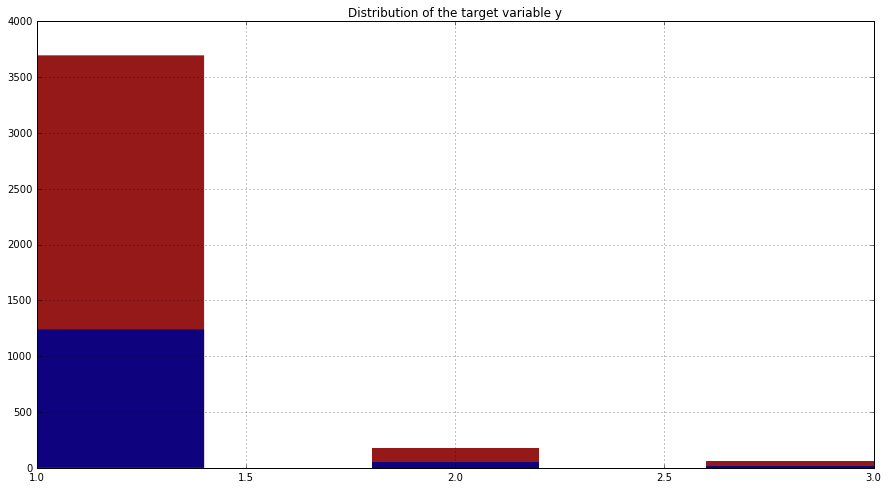

In [89]:
print 'Type 1 in -- Train',flutype_1_in_train , ' out of' ,n_train , '(' , np.round(flutype_1_in_train/n_train,2) * 100, '%) *** Test ',flutype_1_in_test,' out of ',n_test_val, '(',np.round(flutype_1_in_test/n_test_val,2)* 100, '%)'
print 'Type 2 in -- Train',flutype_2_in_train , ' out of' ,n_train , '(' , np.round(flutype_2_in_train/n_train,2) * 100, '%) *** Test ',flutype_2_in_test,' out of ',n_test_val, '(',np.round(flutype_2_in_test/n_test_val,2)* 100, '%)'
print 'Type 3 in -- Train',flutype_3_in_train , ' out of' ,n_train , '(' , np.round(flutype_3_in_train/n_train,2) * 100, '%) *** Test ',flutype_3_in_test,' out of ',n_test_val, '(',np.round(flutype_3_in_test/n_test_val,2)* 100, '%)'

# Display the distribution of response variable in the train data set
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.hist(y_train, color="darkred", alpha=0.9, bins = 5, edgecolor="none")
ax.hist(y_test, color="darkblue", alpha=0.9, bins = 5, edgecolor="none")
ax.set_title('Distribution of the target variable y')
ax.grid()
plt.show()


## Establish the Baseline Models

In [90]:
#Function for computing the accuracy a given model on the entire test set, 
#the accuracy on class 0 
#the accuracy on class 1
def score2(model,x_test,y_test):
    overall_accuracy = model.score(x_test, y_test)
    accuracy_on_class_1 = model.score(x_test[y_test==1], y_test[y_test==1])
    accuracy_on_class_2 = model.score(x_test[y_test==2], y_test[y_test==2])
    accuracy_on_class_3 = model.score(x_test[y_test==3], y_test[y_test==3])

    return  pd.Series([overall_accuracy,  accuracy_on_class_1,accuracy_on_class_2 ,accuracy_on_class_3],
               index=['overall accuracy', 'accuracy on class 1', 'accuracy on class 2','accuracy on class 3'])

In [91]:
# A model that labels everything 1
class Basic_model1(object):
    def predict(self, x):
        return np.array([1] * len(x))
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
# A model that labels everything 2
class Basic_model2(object):
    def predict(self, x):
        return np.array([2] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)


# A model that labels everything 3
class Basic_model3(object):
    def predict(self, x):
        return np.array([3] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
                         
# A model that randomly labels things
class Random_model(object):
    def predict(self, x):
        return np.random.randint(0, 4, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

In [92]:
basic_model1 = Basic_model1()
basic_model1_scores = score2(basic_model1, x_test, y_test)

basic_model2 = Basic_model2()
basic_model2_scores = score2(basic_model2, x_test, y_test)

basic_model3 = Basic_model3()
basic_model3_scores = score2(basic_model3, x_test, y_test)

random_model = Random_model()
random_model_scores = score2(random_model, x_test, y_test)

#Score Dataframe
score_df = pd.DataFrame({'basic_model1': basic_model1_scores,
                         'basic_model2': basic_model2_scores,
                         'basic_model3': basic_model3_scores,
                         'random model': random_model_scores})
score_df

,basic_model1,basic_model2,basic_model3,random model
overall accuracy,0.945122,0.040396,0.014482,0.230945
accuracy on class 1,1.000000,0.000000,0.000000,0.251613
accuracy on class 2,0.000000,1.000000,0.000000,0.245283
accuracy on class 3,0.000000,0.000000,1.000000,0.157895


## Build Models

Note  :  Ignore KNN 
    as the problem state that "The MA state government will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future."
    
    And As the KNN take very long time in prediction so this model will not be suitbale in our case

In [93]:
table(df_flu.flutype)

,flutype
1.0,4936
2.0,227
3.0,83


Modeling

In [94]:
# Unweighted logistic regression
unweighted_logistic = LogisticRegression()
unweighted_logistic.fit(x_train, y_train)

unweighted_log_scores = score2(unweighted_logistic, x_test, y_test)
print 'unweighted log'

# Unweighted quadtratic logistic regression
unweighted__quad_logistic = LogisticRegression()
unweighted__quad_logistic.fit(x_train_quad, y_train_quad)

unweighted_quad_log_scores = score2(unweighted__quad_logistic, x_test_quad, y_test)
print 'unweighted quadratic log'

# Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced')
weighted_logistic.fit(x_train, y_train)

weighted_log_scores = score2(weighted_logistic, x_test, y_test)
print 'weighted log'

# Weighted quadtratic logistic regression
weighted_quad_logistic = LogisticRegression(class_weight='balanced')
weighted_quad_logistic.fit(x_train_quad, y_train_quad)

weighted_quad_log_scores = score2(weighted_quad_logistic, x_test_quad, y_test)
print 'weighted log'

#LDA
lda = LDA()
lda.fit(x_train, y_train)

lda_scores = score2(lda, x_test, y_test)
print 'lda'

#QDA
qda = QDA()
qda.fit(x_train, y_train)

qda_scores = score2(qda, x_test, y_test)
print 'qda'

#Random Forest
rf = RandomForest()
rf.fit(x_train, y_train)

rf_scores = score2(rf, x_test, y_test)

print 'rf'

# Ada boost
ada = ensemble.AdaBoostClassifier(n_estimators=20)
ada.fit(x_train, y_train)

ada_scores = score2(ada, x_test, y_test)

print 'ada boost'



unweighted log
unweighted quadratic log
weighted log
weighted log
lda
qda
rf
ada boost


In [ ]:
start = timeit.timeit()
svm = SVC(C=1000, kernel='linear', class_weight='balanced')
svm.fit(x_train, y_train)
svm_scores = score2(svm, x_test, y_test)
end = timeit.timeit()

print  'svm Weighted Linear'

svm_time = pd.Series([start - end], index=['Model Fit Time'])

In [95]:
#Score Dataframe
score_df = pd.DataFrame({'unweighted logistic': unweighted_log_scores,
                         'weighted logistic': weighted_log_scores,
                         'unweighted quadtratic logistic': unweighted_quad_log_scores,
                         'weighted quadtratic logistic': weighted_quad_log_scores,
                         #'SVM Weighted Linear': svm_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'rf': rf_scores,
                         'ada boost': ada_scores})
score_df

,ada boost,lda,qda,rf,unweighted logistic,unweighted quadtratic logistic,weighted logistic,weighted quadtratic logistic
overall accuracy,0.942073,0.933689,0.089939,0.947409,0.945122,0.001524,0.912348,0.260671
accuracy on class 1,0.994355,0.983871,0.056452,0.999194,1.000000,0.001613,0.957258,0.275806
accuracy on class 2,0.018868,0.018868,0.905660,0.056604,0.000000,0.000000,0.075472,0.000000
accuracy on class 3,0.105263,0.210526,0.000000,0.052632,0.000000,0.000000,0.315789,0.000000


- from the above test it seem that the SVM weighted Linear can be used 

## Costs

**Three Baseline Models:** 
- expected cost on observed data: \$6,818,206.0, \$7,035,735.0, \$8,297,197.5
- time to build: 1 min

**Reasonable Model:** 
- expected cost on observed data: $6,300,000
- time to build: 20 min


In [98]:
print "baseline 1:", cost(y_test, np.repeat(0, len(y_test)))
print "baseline 2:", cost(y_test, np.repeat(1, len(y_test)))
print "baseline 3:", cost(y_test, np.repeat(2, len(y_test)))


baseline 1: 25364732.0
baseline 2: 5808040.0
baseline 3: 16527344.0


It appears that I don't get to the same expeced costs as shown above. My models indicates, that doing nothing, would cost around 25 million Dollars, giving everybody the second early intervention would cost around 5.8 million dollars and giving everybody the more expensive intervention would cost around 16.5 million dollars.

In [99]:
table(pd.Series(y_test)) / len(y_test)


,0
1.0,0.945122
2.0,0.040396
3.0,0.014482


## Production function

In [101]:
def flu_predict(x_test):
    log_model = LogisticRegression(C=10, solver='liblinear', penalty='l2', class_weight='balanced').fit(x_train, y_train)
    test_y_pred = log_model.predict(x_test)
    y_pred = pd.DataFrame(test_y_pred)[0] 
    return y_pred

y_pred = flu_predict(x_test)

y_pred = y_pred - 1
y_true = y_test - 1
cost(y_true, y_pred)

1493444.0

The logisitc regression model only costs 1.5 Million which brings a lot of savings.

## Final prediction

In [2]:
df_flu_fin = pd.read_csv('datasets/flu_test_no_y.csv')
y_pred = pd.Series(flu_predict(x_fin))
df_pred = pd.DataFrame({"id": df_flu_fin.ID, "pred": y_pred})
df_pred.to_csv("datasets/pred2.csv")


NameError: name 'pd' is not defined